# Comparison between local analysis and global analysis

In [1]:
import toml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations_with_replacement

from app.task import load_data, compute_allele_frequencies_np, count_alleles, compute_maf  
# generate_gwas_dataset, 


# Loading parameters from TOML file
toml_file = "pyproject.toml"
config = toml.load(toml_file)
params = config["tool"]["flwr"]["app"]["config"]

num_partitions = 5

## Federated analysis

Here we read the results of the FL process and show the results.

In [2]:
federated_maf = pd.read_csv('./maf_out.csv',index_col=0)
federated_maf

,MAF
SNP_1,0.204992
SNP_2,0.154991
SNP_3,0.149994
SNP_4,0.070005
SNP_5,0.039988


## Centralized analysis

Here, we aggregate the datasets from the different clients participating in the FL process and perform the analysis in a centralized manner. Note that the results are <b>identical</b> to those obtained through FL. However, it's important to note that this approach would not be feasible in a real-world scenario where only FL is authorized.

In [3]:
# Concatenate all partitions into a single dataset
all_partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_snps = params["num_snps"], seed_value =
                     params["seed_value"]
                    )

    if i==0 :
        print("Example of local dataset:")
        display(data)
    all_partitions.append(data)
centralized_df = pd.concat(all_partitions)


Example of local dataset:


,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5
0,AG,AA,GG,TT,AT
1,AG,AA,AA,AT,AA
2,CC,AT,CT,GT,AT
3,AT,AT,AG,TT,AT
4,GG,CG,AG,CG,AA
5,AC,AG,CG,GT,AT
6,AT,GT,AT,CT,AA
7,AT,CT,GT,CG,AT
8,CG,AG,GG,TT,TT
9,GG,CG,AT,AC,AA


In [ ]:
centralized_counts = count_alleles(centralized_df)
centralized_counts

,A_count,C_count,G_count,T_count,Total_Alleles
SNP_1,47,46,66,41,200
SNP_2,87,33,49,31,200
SNP_3,54,30,71,45,200
SNP_4,54,54,14,78,200
SNP_5,103,43,8,46,200


In [5]:
allele_frequencies_np = compute_allele_frequencies_np(centralized_counts)
allele_frequencies_np

array([[0.235, 0.23 , 0.33 , 0.205],
       [0.435, 0.165, 0.245, 0.155],
       [0.27 , 0.15 , 0.355, 0.225],
       [0.27 , 0.27 , 0.07 , 0.39 ],
       [0.515, 0.215, 0.04 , 0.23 ]])

In [7]:
centralized_maf = compute_maf(allele_frequencies_np)
print(f"Centralized MAF: {centralized_maf}")

Centralized MAF: [0.205 0.155 0.15  0.07  0.04 ]


## Local analysis

Here, we present the results each client would obtain by analyzing their dataset independently. Notably, using the default seed value from the configuration file.

In [12]:
# Concatenate all partitions into a single dataset
partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_snps = params["num_snps"], seed_value =
                     params["seed_value"]
                    )

    partitions.append((i,data))
# Compute the MAF for each partition
values= np.stack([compute_maf(compute_allele_frequencies_np(count_alleles(t[1]))) for t in partitions ])


# Prepare the data for the plot
cases = ['Client 1', 'Client 2', 'Client 3', 'Client 4', 'Client 5','Federated Analysis']
categories = ['SNP_1', 'SNP_2', 'SNP_3', 'SNP_4','SNP_5']

# Appending a row with the federated analysis
values =np.vstack([values,federated_maf.MAF.values])

## Plot

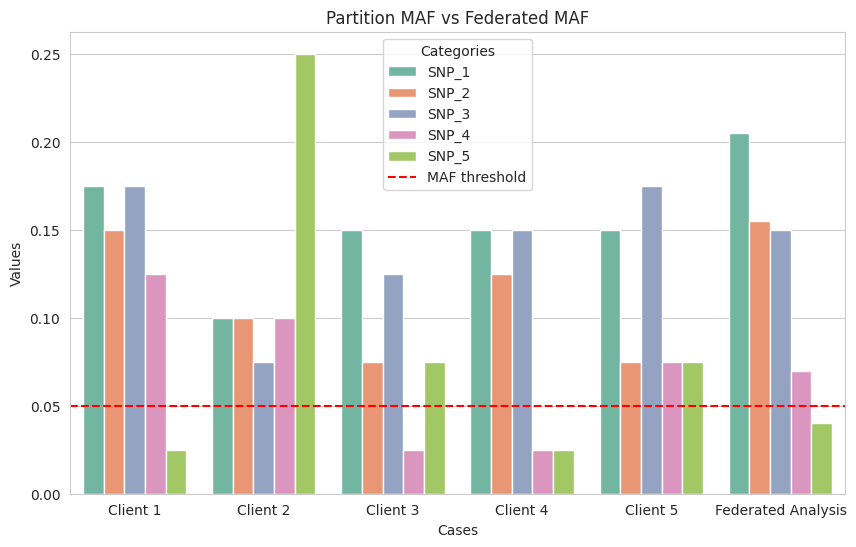

In [13]:
# Set Seaborn style
sns.set_style("whitegrid") 

# Reshape data to long format
data = []
for i, case in enumerate(cases):
    for j, cat in enumerate(categories):
        data.append([case, cat, values[i, j]])

df = pd.DataFrame(data, columns=['Case', 'Category', 'Value'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Case', y='Value', hue='Category', data=df, errorbar=None,palette="Set2")

# Add horizontal threshold line
plt.axhline(0.05, linestyle='--', color='red', label='MAF threshold')

# Formatting
plt.xlabel('Cases')
plt.ylabel('Values')
plt.title('Partition MAF vs Federated MAF')
plt.legend(title='Categories')

# Show plot
plt.show()

In this notebook, we compared the results of federated analysis, centralized analysis, and client-level analysis. First, we demonstrated that centralized and federated analyses yield identical results. Additionally, it is noteworthy that at the client level, specifically in Clients 3 and 4, SNP_4 would have been excluded from the GWAS due to a MAF of less than 0.05, but it is preserved when calculating the MAF through the federated approach. Conversely, SNP_5 would be retained in Clients 2 and 3 but excluded in the federated analysis since the MAF calculated across the entire dataset is less than 0.05.